In [ ]:
import math

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

class TrainTweetDataset(Dataset):
    def __init__(self, n_blocs, data_dir, device, transform=None, target_transform=None):
        self.n_blocs = n_blocs
        self.device = device
        self.labels = {idx: torch.load(data_dir+f"y_train_cnn_new_{idx}_full.pt", self.device)
                       for idx in range(n_blocs)}
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_blocs

    def __getitem__(self, idx):
        train_data = torch.load(self.data_dir+f"X_train_cnn_new_{idx}_full_3CH.pt", self.device)
        #train_data = train_data.view(train_data.shape[0], 3, 50, 20)
        labels = self.labels[idx]
        if self.transform:
            train_data = self.transform(train_data)
        if self.target_transform:
            labels = self.target_transform(labels)
        return train_data, labels

class TestTweetDataset(Dataset):
    def __init__(self, n_blocs, data_dir, device, transform=None, target_transform=None):
        self.device = device
        self.n_blocs = n_blocs
        self.labels = {idx: torch.load(data_dir+f"y_test_cnn_new_{idx}_full.pt", self.device)
                       for idx in range(n_blocs)}
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_blocs

    def __getitem__(self, idx):
        test_data = torch.load(self.data_dir+f"X_test_cnn_new_{idx}_full_3CH.pt", self.device)
        #test_data = test_data.view(test_data.shape[0], 3, 50, 20)
        labels = self.labels[idx]
        if self.transform:
            test_data = self.transform(test_data)
        if self.target_transform:
            labels = self.target_transform(labels)
        return test_data, labels


In [ ]:
def train_loop(X_train, epochs, learning_rate, model, l, y_train):
    batch_size = BATCH_SIZE
    pred_train=[]
    Nb_tweets=X_train.shape[0]
    threshold = 0.5
    # y_train = y_train.type(torch.LongTensor)
    y_train[y_train == -1] = 1  # between 0 and 1 instead of -1 and 0
    o=torch.optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    # initialize an empty dictionary
    res = {'epoch': [], 'train_loss': []}
    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------")
        running_loss=0
        permutation = torch.randperm(X_train.size()[0])
        for i in range(0, X_train.size()[0], batch_size):
            if i%10000 == 0:
                print(f"Tweet {i}")
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]
            outputs = model(batch_x)
            #binary_predictions = (outputs >= threshold).float()
            pred_train.append(outputs)
            o.zero_grad() # setting gradient to zeros, bc I don't wanna accumulate the grads of all layers
            loss = l(outputs, batch_y)
            loss.backward() # backward propagation
            o.step() # update the gradient to new gradients
            running_loss += loss.item()
        running_loss=running_loss/batch_size
        res['epoch'].append(e) # populate the dictionary of results
        res['train_loss'].append(running_loss)
    print("Done!")
    res = pd.DataFrame.from_dict(res) # translate the dictionary into a pandas dataframe
    res.to_csv("./metrics_over_epochs_0{:.5f}.csv".format(learning_rate), mode = 'w', index = False) # store the results into a *.csv file
    return res['train_loss'], pred_train

In [ ]:
# =============================== CONSTANTS ===============================
# Main directory path
PREFIX = '/content/drive/MyDrive/Colab Notebooks/batches/small/'
# Number of blocs of data
N_BLOCS = 6
# Batch size inside a bloc
BATCH_SIZE = 500
# Number of features, equivalent to the embedding size
N_FEATURES = 20
# Number of channels, equivalent to the number of different embedding used
N_CHANNELS = 3
# Truncated length of tweets
LEN_TWEET = 50
# =========================================================================

In [ ]:
def device_type():
    if torch.cuda.is_available():
        return 'cuda:0'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
device = torch.device(device_type())
print(f"device={device}")

device=cuda:0


In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size1, hidden_size2, kernel_size, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size[0], out_channels=hidden_size, kernel_size=kernel_size, stride=N_FEATURES, padding=0)#(d - kernel_size + 1) / 1 = (10000 - 3 + 1) / 1 = 9999
        output1=(input_size[1]-kernel_size+1)/(kernel_size/2)+1
        #print("output1 after conv1", output1)
        self.relu1 = nn.ReLU()

        self.pool_kernel_size = 3
        self.pool_stride = 1
        self.pool1 = nn.MaxPool1d(kernel_size=self.pool_kernel_size, stride=self.pool_stride)
        output2=(output1-self.pool_kernel_size+1)/1
        #print("output2 after pool1", output2)

        self.conv1d_kernel_size = 2
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size1, kernel_size=self.conv1d_kernel_size, stride=1, padding=1)
        output3=(output2-self.conv1d_kernel_size+2*1)/1+1
        #print("output3, after conv2", output3)
        self.relu2 = nn.ReLU()
        self.pool2_kernel_size = 2
        self.pool2 = nn.MaxPool1d(kernel_size=self.pool2_kernel_size, stride=self.pool_stride)
        self.output4=math.floor((output3-self.pool2_kernel_size+1)/self.pool_stride)
        #print("output4 after pool2 = ", self.output4)
        self.fc1 = nn.Linear(BATCH_SIZE*self.output4, hidden_size2)
        self.fc_last = nn.Linear(2664, hidden_size2)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size2, output_size)


        #self.softmax=nn.Softmax(dim= 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        #print(x.shape)
        if x.shape[0]!=BATCH_SIZE and x.shape[0]!=0:
          x = x.view(x.shape[0], 3, -1)
        else:
          x = x.view(BATCH_SIZE,3,-1)#1,980

        #print(f"x.view(batch_size,3,-1) {x.shape}")
        x = self.conv1(x) #12,48
        #print(f"self.conv1(x) {x.shape}")
        x = self.relu1(x)
        x = self.pool1(x)#12,46
        #print(f"self.pool1(x) {x.shape}")
        x = self.conv2(x)#1,47
        #print(f"self.conv2(x) {x.shape}")
        x = self.relu2(x)
        x = self.pool2(x)#1,46
        #print(f"self.pool2(x) {x.shape}")
        x = x.view(x.size(0),-1)
        #print(f"x.view(x. {x.shape}")

        if x.shape[1]!=BATCH_SIZE*self.output4:
          x = self.fc_last(x)
          #print("x.shape boucle if =", x.shape)
        else:
          x = self.fc1(x)#1,16
          #print(f"self.fc1(x) {x.shape}")
        #print("x.shape after fc1 =", x.shape)
        x = self.relu3(x)
        #print("x.shape after relu =", x.shape)
        x = self.fc2(x)
        #print(f"self.fc2(x) {x.shape}")

        #x = self.softmax(x)
        #x = self.sigmoid(x)
        x = x.flatten()
        #print("after flatten shape = ", x.shape)
        return x

In [ ]:
def plot_loss_vs_lr(losses, learning_rates, filename):
    plt.figure(figsize=(8, 6))
    for i in range(len(learning_rate)):
        plt.plot(np.arange(0,epochs,1), losses[i], label=f'Learning rate = {learning_rates[i]}')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Train Error')
    plt.grid(True)
    plt.legend(loc='upper right', title='train loop', fontsize='medium')
    plt.savefig(filename)


In [ ]:
train_ds = TrainTweetDataset(6, PREFIX, device)
test_ds = TestTweetDataset(6, PREFIX, device)
train_dataloader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [ ]:
# MODEL DEFINITION
input_channels = N_CHANNELS
nb_features = N_FEATURES
len_tweet = LEN_TWEET

hidden_size = 12
hidden_size1 = BATCH_SIZE
hidden_size2 = 16
kernel_size = nb_features*2
output_size = 1

model = CNN(input_size=(input_channels,len_tweet*nb_features),
        hidden_size=hidden_size,
        hidden_size1=hidden_size1,
        hidden_size2=hidden_size2,
        kernel_size=kernel_size,
        output_size=output_size)

model = model.to(device)

epochs=1 # ONLY ONE EPOCH FOR EXAMPLE
learning_rate = np.logspace(-5,-1, 1)
l= torch.nn.CrossEntropyLoss()

In [ ]:
# MODEL TRAINING
for idx_bloc in range(N_BLOCS-4): # ONLY FIRST 2 BLOCS FOR EXAMPLE
    print(f"Training bloc {idx_bloc}. Loading data...")
    X_train, y_train = next(iter(train_dataloader))
    X_train = X_train.squeeze()
    y_train = y_train.squeeze()
    X_train = X_train.flatten(2)
    losses = []
    print("Done loading data, Training...")
    for lr in learning_rate:
        loss = train_loop(X_train, epochs, lr, model, l, y_train)
        losses.append(loss)
    print("Done training.")
    del X_train, y_train
    #plot_loss_vs_lr(losses, learning_rate, f'loss_vs_lr_bloc_{idx_bloc}.png')

Training bloc 0. Loading data...
Done loading data, Training...
Epoch 1
-------------------------------
Tweet 0
Tweet 10000
Tweet 20000
Tweet 30000
Tweet 40000
Tweet 50000
Tweet 60000
Tweet 70000
Tweet 80000
Tweet 90000
Tweet 100000
Tweet 110000
Tweet 120000
Tweet 130000
Tweet 140000
Tweet 150000
Tweet 160000
Tweet 170000
Tweet 180000
Tweet 190000
Tweet 200000
Tweet 210000
Tweet 220000
Tweet 230000
Tweet 240000
Tweet 250000
Tweet 260000
Tweet 270000
Tweet 280000
Tweet 290000
Done!
Done training.
Training bloc 1. Loading data...
Done loading data, Training...
Epoch 1
-------------------------------
Tweet 0
Tweet 10000
Tweet 20000
Tweet 30000
Tweet 40000
Tweet 50000
Tweet 60000
Tweet 70000
Tweet 80000
Tweet 90000
Tweet 100000
Tweet 110000
Tweet 120000
Tweet 130000
Tweet 140000
Tweet 150000
Tweet 160000
Tweet 170000
Tweet 180000
Tweet 190000
Tweet 200000
Tweet 210000
Tweet 220000
Tweet 230000
Tweet 240000
Tweet 250000
Tweet 260000
Tweet 270000
Tweet 280000
Tweet 290000
Done!
Done training

In [ ]:
losses

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: ignored

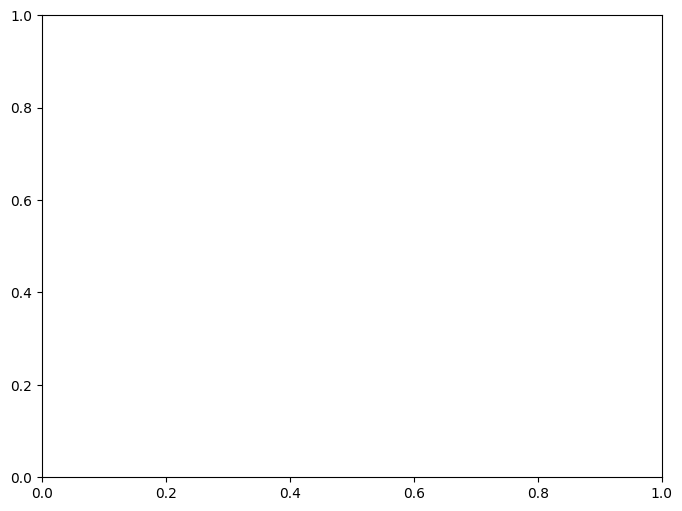

In [ ]:
plot_loss_vs_lr(losses, learning_rate, "test.png")

In [ ]:
def test_loop(X_test,y_test, l, model):
    #y_test=y_test[:,0]*(-1)
    pred_test=[]
    batch_size = BATCH_SIZE
    test_loss=0
    model.eval()
    threshold = 0.5
    with torch.no_grad():
        # loop over all test input-output pairs
        permutation = torch.randperm(X_test.size()[0])
        for i in range(0, X_test.size()[0], batch_size):
            if i%1000 == 0:
                print(f"Tweet {i}")
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_test[indices], y_test[indices]
            outputs = model(batch_x)
            #pred_test_np = torch.cat(outputs).detach().numpy()
            #binary_predictions = (pred_test_np > threshold).astype(int)
            pred_test.append(outputs)
            #print("outputs",outputs.shape)
            #print("batchy",batch_y)
            loss = l(binary_predicions, batch_y)
            test_loss += loss.item()
        test_loss=test_loss/batch_size
    return test_loss, pred_test

In [ ]:
test_loss, y_pred1= test_loop(X_test, y_test, l, model)
print("test_loss", test_loss)
#print("y_pred1", y_pred1)




In [ ]:
def test_loop_final(X_test, model):
    pred_test=[]
    batch_size = BATCH_SIZE
    test_loss=0
    model.eval()
    with torch.no_grad():
      # loop over all test input-output pairs
        permutation = torch.randperm(X_test.size()[0])
        for i in range(0, X_train.size()[0], batch_size):
            if i%1000 == 0:
                print(f"Tweet {i}")
            indices = permutation[i:i+batch_size]
            batch_x = X_test[indices]
            outputs = model(batch_x)
            pred_test.append(outputs)
            #print("outputs",outputs.shape)
            #print("batchy",batch_y)

    return pred_test

In [ ]:
y_pred_final =  test_loop_final(X_T, model)